In [1]:
import os
import json
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
# dataset_name = 'prepared_facebook_data'
# folder_name = 'facebook_comm_vol'
# dataset_name ='house_prices'
# folder_name = 'boston_house_prices'
# dataset_name = 'energy_consumption'
# folder_name = 'energy_consumption'
dataset_name = 'physics'
folder_name = 'physics'

path = f"../../other_data_experiments/{folder_name}/"
fourth_test_path = path + "fourth experiment/prepared/"
third_test_path = path + "third experiment/"
GRAPHS_DIR = path + "graphs/"

In [4]:
grid_file = path + f"first experiment/res_grid_search_{dataset_name}.csv"

bayes_opt_files = [third_test_path + f"bayes_opt_{i}_{dataset_name}.csv"
                       for i in range(1,11)]

random_search_files = [f"first experiment/res_rand_{dataset_name}_{i}.csv"
                       for i in range(1,11)]

In [5]:
grid_df = pd.read_csv(grid_file, usecols = ['experiment_name',
                                           'mean_test_score',
                                           'params'])
grid_df['run_number']=1
grid_df['iter_num'] = range(1, grid_df.shape[0]+1)    

default_df = pd.read_csv(path + f"first experiment/res_default_{dataset_name}.csv", 
                         usecols = ['experiment_name',
                                    'mean_test_score',
                                    'params'])
default_df['run_number']=1
default_df['iter_num'] = range(1, default_df.shape[0]+1)    

In [6]:
bayes_df = pd.DataFrame([])
for file_name in bayes_opt_files:
    file_df = pd.read_csv(file_name, 
                          usecols = ['experiment_name', 'mean_test_score',
                                     'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    bayes_df = pd.concat([bayes_df, file_df], sort = False)

In [7]:
iters_info = {}
scores_info = {}

# set stop criterion

In [8]:


stop_iter_num = 10
# 10, 25, 50 #, 100


In [9]:
bayes_group_files_with_stop = [fourth_test_path + \
                               f"GRBO_groups_with_{stop_iter_num}_{i}_{dataset_name}.csv"
                               for i in range(1,11)]

In [10]:
full_bayes_group_with_stop = pd.DataFrame([])

for file_name in bayes_group_files_with_stop:
    file_df = pd.read_csv(file_name, 
                         usecols = ['experiment_name', 'mean_test_score',
                                     'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    full_bayes_group_with_stop = pd.concat([full_bayes_group_with_stop, file_df], sort = False)

In [11]:
scores = full_bayes_group_with_stop.groupby('run_number')['mean_test_score'].max()
print("MEAN best score:", np.mean(scores))
print("STD best score:", np.std(scores))
print(f"{np.round(np.mean(scores), 4)} _ {np.round(np.std(scores), 4)}")

MEAN best score: 0.8995342869762641
STD best score: 0.0001766413829512574
0.8995 _ 0.0002


In [12]:
iters_num = full_bayes_group_with_stop.groupby(by='run_number')['iter_num'].max()
print("MEAN iters num:", np.mean(iters_num))
# print("STD iters num:", np.std(iters_num))
max_iter = np.round(np.max(iters_num))
min_iter = np.round(np.min(iters_num))
print("MAX iters num:", max_iter)
print("MIN iters num:", min_iter)
print(f"min: {int(min_iter)}\nmean: {int(np.round(np.mean(iters_num)))}\nmax: {int(max_iter)}")

MEAN iters num: 586.7
MAX iters num: 807
MIN iters num: 257
min: 257
mean: 587
max: 807


In [13]:
max_score_and_iter = full_bayes_group_with_stop.groupby(by = 'run_number')[['mean_test_score', 'iter_num']].max()

full_bayes_group_with_stop = full_bayes_group_with_stop.loc[:, ['mean_test_score', 'iter_num', 'run_number']]

In [14]:
# Продление конечной оценки до максимальной итерации 
# для отрисовки конца доверительного интервала

In [15]:
list_for_extension = list(max_score_and_iter.loc[
        max_score_and_iter.iter_num < max_iter].index)

full_bayes_group_with_stop = full_bayes_group_with_stop.dropna(how = 'all')

In [16]:
agg_df_GRS = full_bayes_group_with_stop.groupby('run_number')['iter_num'].max().values

iters_info['GRBO_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_GRS), 
    'std':np.nanstd(agg_df_GRS)
}

In [17]:
for run_number in list_for_extension:
    new_part_df = pd.DataFrame([], columns=full_bayes_group_with_stop.columns)
    new_part_df['iter_num']=range(int(max_score_and_iter.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df['run_number'] = run_number
    new_part_df['mean_test_score'] = max_score_and_iter.loc[run_number, 
                                                            'mean_test_score']
    full_bayes_group_with_stop = pd.concat([full_bayes_group_with_stop, new_part_df], sort = False)
    
stopped_full_df = pd.DataFrame([])
for run_number in np.unique(full_bayes_group_with_stop.run_number):
    copy_df = full_bayes_group_with_stop.loc[full_bayes_group_with_stop.run_number == run_number].sort_values(by = 'iter_num')
    copy_df['mean_test_score']=copy_df['mean_test_score'].cummax()
    copy_df['run_number']=run_number
    #full_df.loc[full_df.run_number == run_number]=full_df.loc[full_df.run_number == run_number].sort_values(by = 'iter_num')
    #full_df.loc[full_df.run_number == run_number, 'mean_test_score'] = \
    #    full_df.loc[full_df.run_number == run_number, 'mean_test_score'].cummax()
    stopped_full_df = pd.concat([stopped_full_df, copy_df], sort=False)


In [18]:
full_bayes_group_with_stop = stopped_full_df
full_bayes_group_with_stop['experiment_name']='group bayes opt'

In [19]:
## BAYES OPT
#get best scores per itration for each bayes_opt performance:
bo_df_stopped=pd.DataFrame([])
max_iters_for_BO = []
for i in bayes_df.run_number.unique():    
    tmp=pd.DataFrame(bayes_df.loc[bayes_df.run_number==i, 
                                   "mean_test_score"].copy().cummax())
    tmp["iter_num"]=bayes_df.loc[bayes_df.run_number==i, "iter_num"]
    curr_max=tmp.groupby("mean_test_score").count().reset_index()
    max_score=curr_max.loc[curr_max["iter_num"]>=stop_iter_num, 
                           "mean_test_score"].values[0]
    
    tmp_before=tmp.loc[tmp["mean_test_score"]<max_score] #get steps before stop criterion
    tmp_stop=tmp.loc[tmp["mean_test_score"]==max_score].sort_values(by="iter_num")
    tmp_stop=tmp_stop.iloc[:stop_iter_num]
    df_stopped=pd.concat([tmp_before, tmp_stop], sort = False)  
    df_stopped['run_number']=i
    max_iters_for_BO.append(df_stopped.shape[0])
    bo_df_stopped=pd.concat([bo_df_stopped, df_stopped], sort=False)
    
    
print("MEAN iters num:", np.mean(max_iters_for_BO))
print("STD iters num:", np.std(max_iters_for_BO))
print("MAX iters num:", np.max(max_iters_for_BO))

print(f"min: {int(np.round(np.min(max_iters_for_BO)))}\nmean: {int(np.round(np.mean(max_iters_for_BO)))}\nmax: {int(np.round(np.max(max_iters_for_BO)))}")

MEAN iters num: 14.3
STD iters num: 6.0174745533321525
MAX iters num: 29
min: 10
mean: 14
max: 29


In [20]:
iters_info['BO_{}'.format(stop_iter_num)] = {
    'mean':np.mean(max_iters_for_BO), 
    'std':np.nanstd(max_iters_for_BO)
}

In [21]:
last_iter = bo_df_stopped.groupby(by='run_number')['iter_num'].max().reset_index()

In [22]:
max_iter = np.max(max_iters_for_BO)
max_score_and_iter_BO = bo_df_stopped.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()
for run_number in list(max_score_and_iter_BO.loc[
        max_score_and_iter_BO.iter_num < max_iter].index):
    new_part_df = pd.DataFrame([], columns=bo_df_stopped.columns)
    new_part_df['iter_num']=range(int(max_score_and_iter_BO.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df[['mean_test_score', 'run_number']] = max_score_and_iter_BO.loc[run_number, 'mean_test_score'], run_number
    bo_df_stopped = pd.concat([bo_df_stopped, new_part_df])
bo_df_stopped['experiment_name']='bayes opt'   

<ipython-input-22-bcdeb8a71752>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_score_and_iter_BO = bo_df_stopped.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()


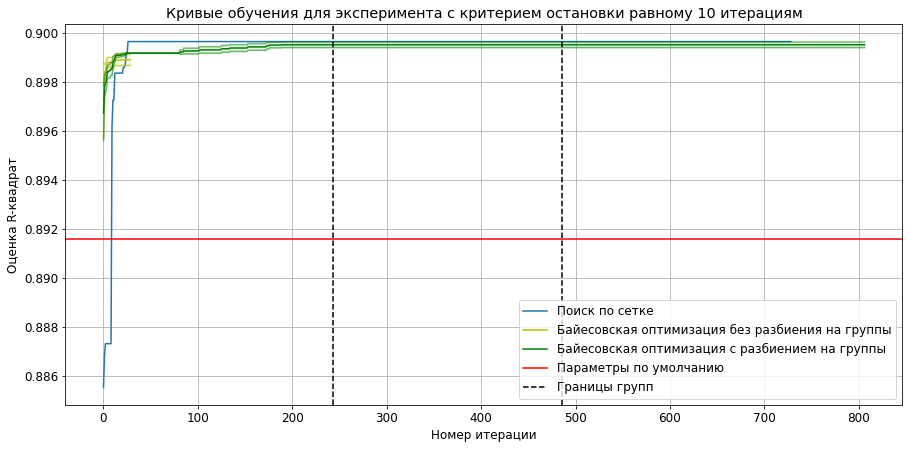

In [23]:
# Data with stop criterion
# stop if the cumulative score hasn't grown in "stop_iter_num" iterations
# GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params',
                      'mean_test_score'].cummax()


## BAYES OPT
# get best scores per itration for each bayes_opt performance:
# bo_df_stopped
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=10
bo_std=bo_df_stopped.groupby(by="iter_num")['mean_test_score'].std() #std
bo_std=(bo_std*z)/np.sqrt(n) #confidence interval value 
bo_mean=bo_df_stopped.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_BAYES_OPT
#get best scores per itration for each group_bayes_opt performance (same computations):

n=10
group_std=full_bayes_group_with_stop.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_std=group_std.fillna(0)
group_mean=full_bayes_group_with_stop.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=default_df.loc[:,'mean_test_score'].values[0]


## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#grid plot:
x=list(range(0, grid_perf.shape[0]))
plt.plot(x, grid_perf, label="Поиск по сетке")

#conf for bayes opt:
x=list(range(0, bo_mean.shape[0]))
plt.plot(x, bo_mean, color="y", label="Байесовская оптимизация без разбиения на группы")
lower_bo=bo_mean - bo_std
upper_bo=bo_mean + bo_std
plt.plot(x, lower_bo, alpha=0.7, color="y")
plt.plot(x, upper_bo, alpha=0.7, color="y")
plt.fill_between(x, lower_bo, upper_bo, alpha=0.1, color="y") 

#conf for group bayes opt:
x=list(range(0, group_mean.shape[0]))
plt.plot(x, group_mean, color="green", label="Байесовская оптимизация с разбиением на группы")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf, label="Параметры по умолчанию", color='r')
plt.axvline(243, label="Границы групп", color='k', ls = "--")
plt.axvline(243*2, color='k', ls = "--")

plt.legend()
plt.title(f"Кривые обучения для эксперимента с критерием остановки равному {stop_iter_num} итерациям")
plt.ylabel("Оценка R-квадрат")
plt.xlabel("Номер итерации")
plt.savefig(GRAPHS_DIR+f"BO_scores_with_stop_{stop_iter_num} {dataset_name}.jpg")
plt.show()

In [24]:
agg_df_GRBO = full_bayes_group_with_stop.groupby('run_number')['mean_test_score'].max().values
agg_df_BO = bo_df_stopped.groupby('run_number')['mean_test_score'].max().values

In [25]:
scores_info[f'GRBO_{stop_iter_num}'] = {
    'mean':np.mean(agg_df_GRBO), 
    'std':np.nanstd(agg_df_GRBO)
}
scores_info[f'BO_{stop_iter_num}'] = {
    'mean':np.mean(agg_df_BO), 
    'std':np.nanstd(agg_df_BO)
}

In [26]:
print(f"{np.round(np.mean(agg_df_BO), 4)} _ {np.round(np.nanstd(agg_df_BO), 4)}")

0.8989 _ 0.0004


In [27]:
scores_info

{'GRBO_10': {'mean': 0.8995342869762641, 'std': 0.0001766413829512574},
 'BO_10': {'mean': 0.8989213499863826, 'std': 0.00035834631595346137}}

In [28]:
iters_info

{'GRBO_10': {'mean': 586.7, 'std': 162.30036968534606},
 'BO_10': {'mean': 14.3, 'std': 6.0174745533321525}}

In [29]:
with open(path + "fourth experiment/BO_scores_info.txt", 'w') as outfile:
    json.dump(scores_info, outfile)
    

with open(path + "fourth experiment/BO_iters_info.txt", 'w') as outfile:
    json.dump(iters_info, outfile)

